In [1]:
%load_ext autoreload
%autoreload 2

# Simulation settings

In [2]:
L = 8
J = 1
h = 0.05
lamb = 0.5

particle_pair_left_position = 3
particle_pair_length = 1

final_time = 4
layers = 15
measure_every_layers = 1

# Device selection

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService
# from cobos.tokens import ibm_token, group_instance
from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
device = "ibm_kyiv"
device = "ibm_fez"
# device = "ibm_sherbrooke"

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

# Circuit transpilation

Longest circuit has 60 2-qb depth


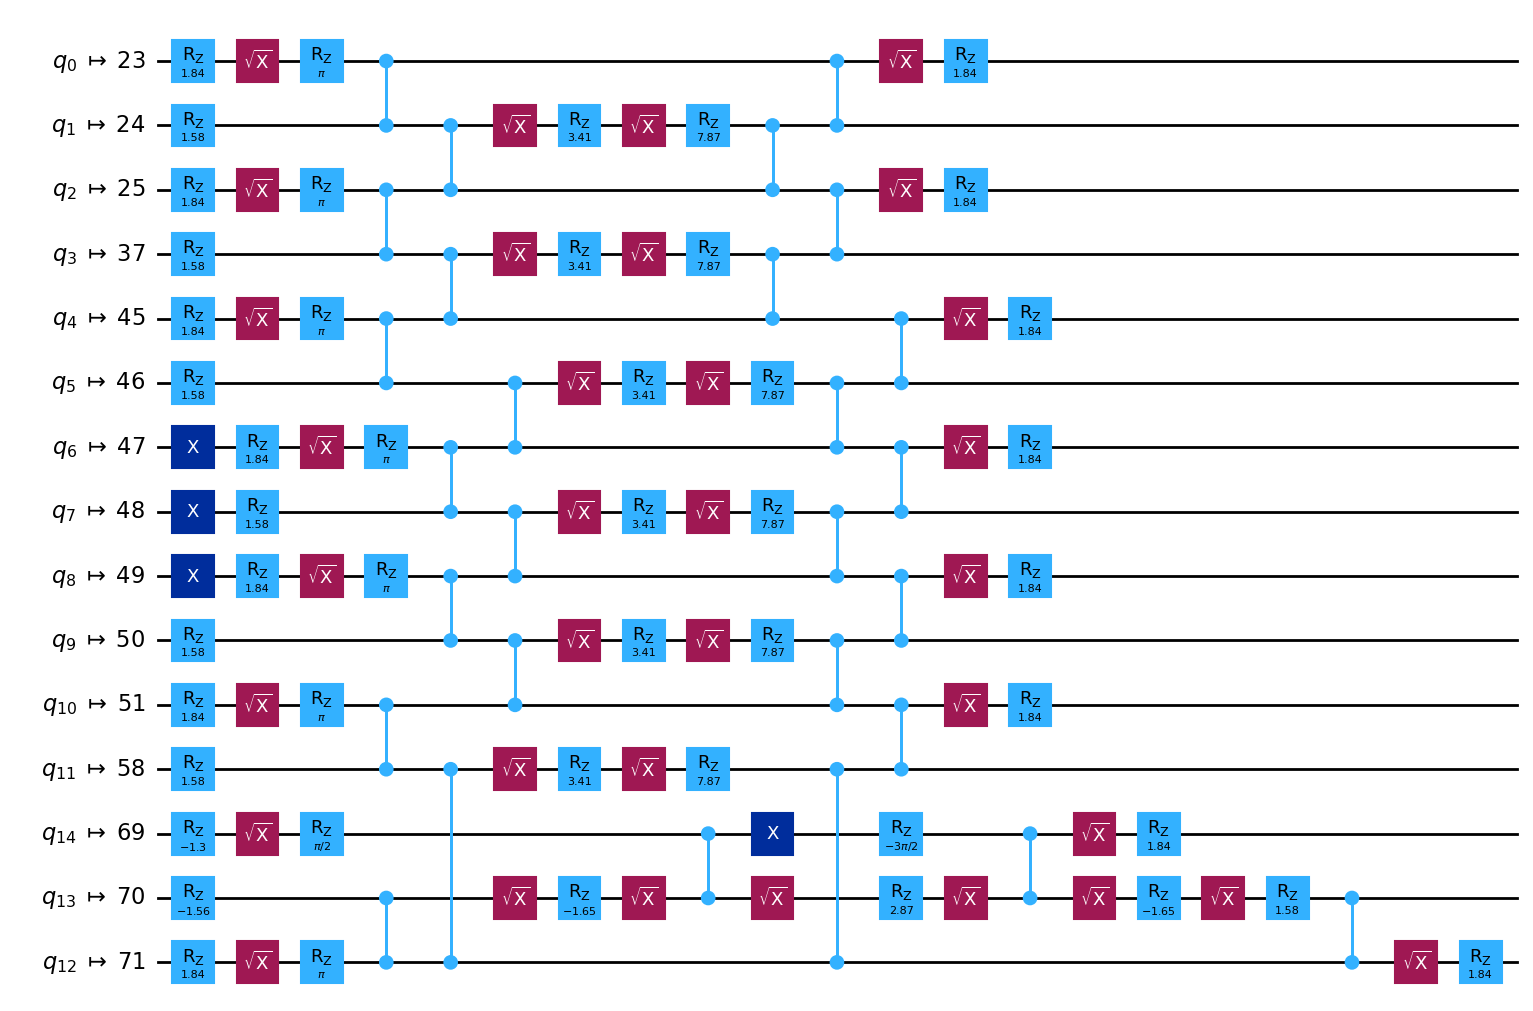

In [16]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits

optimization_level = 2

qubits_inds = None
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22]
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22, 21, 20, 33, 39, 40,
#                41, 42, 43, 44, 45, 54, 64, 63, 62, 72, 
#                81, 82, 83, 92, 102, 103, 104, 111, 122,
#                121, 120, 119, 118, 116, 115, 114, 109, 96, 95]

physical_circuits = physical_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, backend, optimization_level, qubits_inds, measure_every_layers=measure_every_layers)
longest_2qb_depth = physical_circuits[-1].depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
physical_circuits[1].draw(output="mpl", idle_wires=False, fold=-1)

In [17]:
physical_circuits[15].depth(lambda x: len(x.qubits) == 2)

60

## Improving Depth

If we look at one layer before transpilation, it looks like this

Longest circuit has 7 2-qb depth


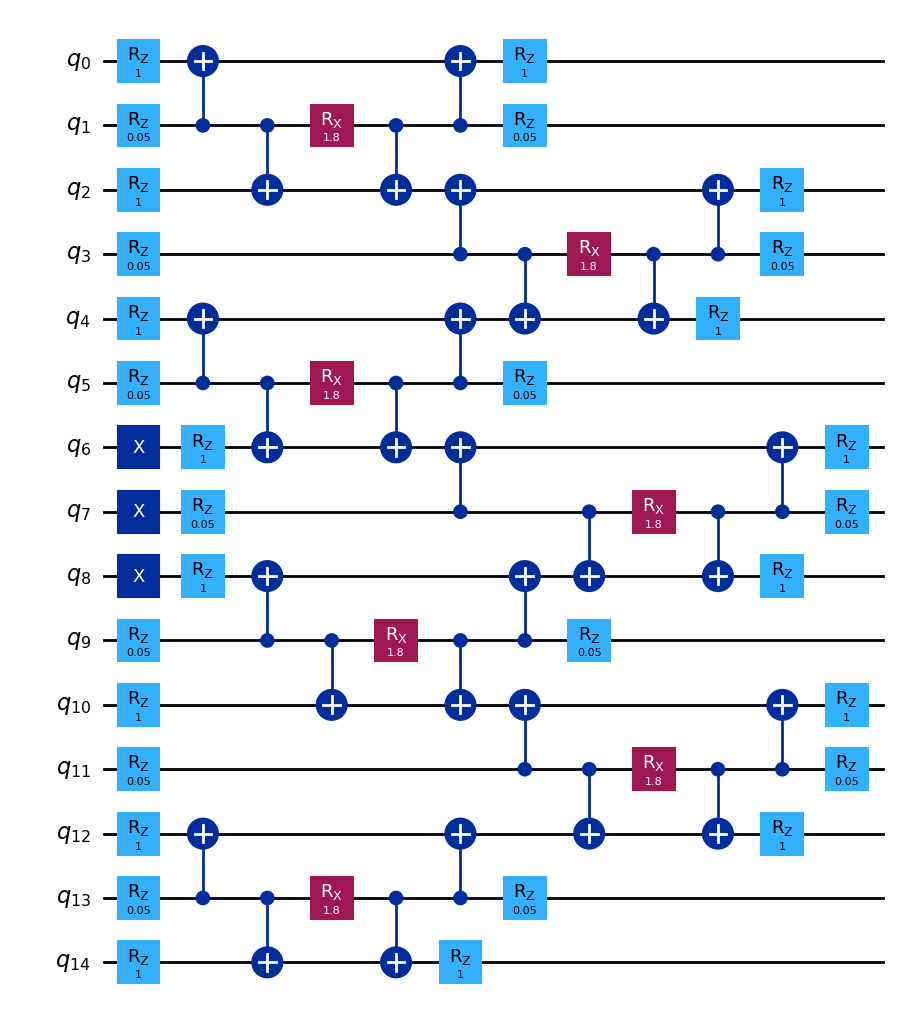

In [87]:
from z2chain.circs import *

initial_state_preparation_circ = particle_pair_initial_state(L, particle_pair_left_position, particle_pair_length)
logical_trotter_layer_circ = SecondOrderTrotter(L, J, h, lamb, final_time/layers, 1, barriers=False)
circ1 = initial_state_preparation_circ.compose(logical_trotter_layer_circ)
longest_2qb_depth = circ1.depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
circ1.draw('mpl', idle_wires=False, fold=-1)

We can see we choose an even odd approach in placing our interaction terms (mass,gauge,mass).  
But the terms actually can commute and we can perform in parallel some operations to reduce the depth.

In [88]:
from z2chain.circs import *

class LowDepthLocalInteractionPropagatorFirst(QuantumCircuit):
    def __init__(self):
        super().__init__(2)
        self.cx(1, 0)

class LowDepthLocalInteractionPropagatorSecond(QuantumCircuit):
    def __init__(self):
        super().__init__(2)
        self.cx(0, 1)


class LowDepthTotalInteractionPropagator(QuantumCircuit):
    def __init__(self, chain_length):
        nqubits = 2*chain_length - 1
        qubit_list = np.arange(nqubits)
        int_qb_inds_first = np.array(qubit_list[:-1])
        int_qb_inds_second = np.array(qubit_list[1:])
        t = Parameter("t")
        super().__init__(nqubits)
        local_prop1 = LowDepthLocalInteractionPropagatorFirst()
        local_prop2 = LowDepthLocalInteractionPropagatorSecond()
        local_prop_instruction1 = circuit_to_instruction(local_prop1)
        local_prop_instruction2 = circuit_to_instruction(local_prop2)
        for qubits in int_qb_inds_first.reshape((len(int_qb_inds_first)//2, 2)):
            self.append(local_prop_instruction1, list(qubits))

        for qubits in int_qb_inds_second.reshape((len(int_qb_inds_second)//2, 2)):
            self.append(local_prop_instruction2, list(qubits))

        for qubits in range(nqubits):
            if qubits%2 == 1:
                self.rx(2*t, qubits)

        for qubits in int_qb_inds_second.reshape((len(int_qb_inds_second)//2, 2)):
            self.append(local_prop_instruction2, list(qubits))

        for qubits in int_qb_inds_first.reshape((len(int_qb_inds_first)//2, 2)):
            self.append(local_prop_instruction1, list(qubits))

def LowDepthSecondOrderTrotter(chain_length, J, h, lamb, t_total, layers, barriers=False):
    t_layer = t_total/layers
    total_interaction_propagator = LowDepthTotalInteractionPropagator(chain_length).decompose()
    total_interaction_propagator.assign_parameters([lamb*t_layer], inplace=True)
    total_single_body_propagator = TotalSingleBodyPropagator(chain_length)
    total_single_body_propagator.assign_parameters([h*t_layer/2, t_layer*J/2], inplace=True)
    layer = total_single_body_propagator.compose(total_interaction_propagator).compose(total_single_body_propagator)
    if barriers: layer.barrier()
    return layer.repeat(layers).decompose()

Longest circuit has 4 2-qb depth


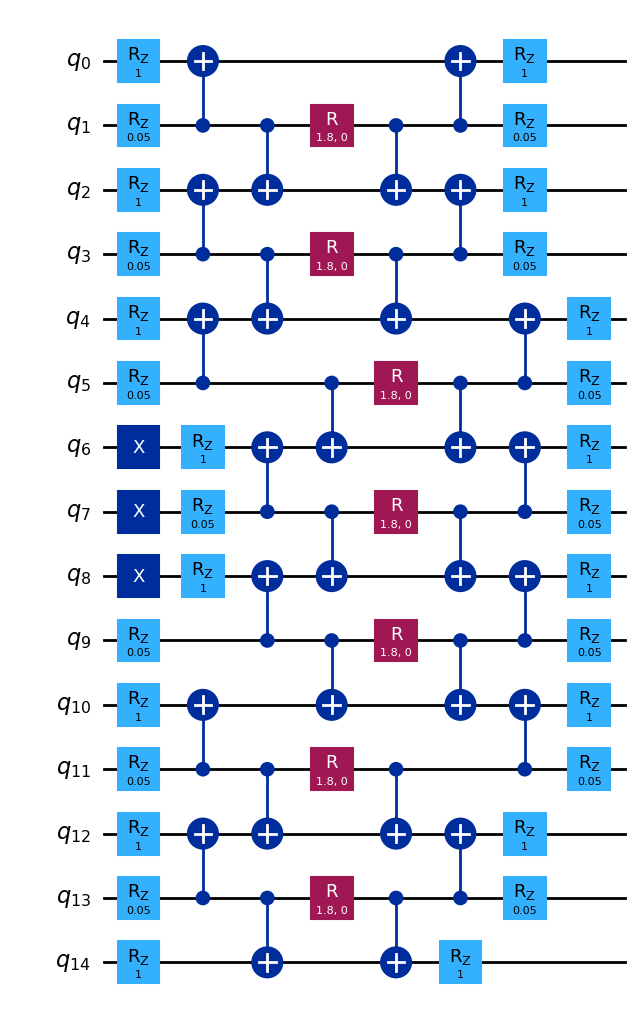

In [89]:
initial_state_preparation_circ = particle_pair_initial_state(L, particle_pair_left_position, particle_pair_length)

logical_trotter_layer_circ = LowDepthSecondOrderTrotter(L, J, h, lamb, final_time/layers, 1, barriers=False)
circ2 = initial_state_preparation_circ.compose(logical_trotter_layer_circ)
longest_2qb_depth = circ2.depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
circ2.draw('mpl', idle_wires=False, fold=-1)

Let us test if the states are the same after the first layer

In [90]:
from qiskit.quantum_info import Statevector

vec1 = Statevector.from_instruction(circ1).data
vec2 = Statevector.from_instruction(circ2).data
print(f"Fidelity: {vec1.conjugate().T @ vec2}")

Fidelity: (1.0000000000000022+4.7704895589362195e-18j)


Let us check the depth improvement

In [ ]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits

optimization_level = 2

qubits_inds = None
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22]

depth = "low"
physical_circuits_new = physical_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, backend, optimization_level, qubits_inds, depth=depth, measure_every_layers=measure_every_layers)
longest_2qb_depth = physical_circuits_new[-1].depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
physical_circuits_new[1].draw(output="mpl", idle_wires=False, fold=-1)

We reduced the 2-qubit depth from $121$ to $80$ for $20$ layers.

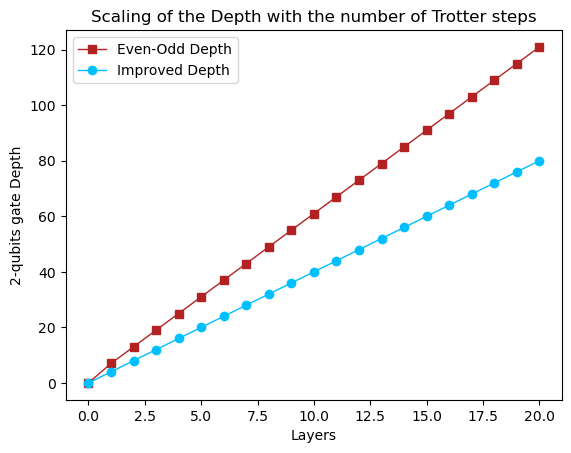

In [96]:
import matplotlib.pyplot as plt

depths = [physical_circuits[i].depth(lambda x: len(x.qubits) == 2) for i in range(len(physical_circuits))]
depths_new = [physical_circuits_new[i].depth(lambda x: len(x.qubits) == 2) for i in range(len(physical_circuits_new))]

plt.title("Scaling of the Depth with the number of Trotter steps")
plt.plot(depths, color="firebrick", marker='s', linewidth=1, label="Even-Odd Depth")
plt.plot(depths_new, color="deepskyblue", marker='o', linewidth=1, label="Improved Depth")
plt.xlabel("Layers")
plt.ylabel("2-qubits gate Depth")
plt.legend()

In [20]:
physical_circuits = physical_circuits_new

# Estimator circuit execution

### Options

In [21]:
from utils.hexec import execdb

execution_database = "z2_chain_jobs.json"

zne_mitigation = "exponential"
measure_mitigation = True
dynamical_decoupling = "XY4"
estimator_options = {
    "default_shots": 10000,
    "optimization_level": 0,
    "resilience_level": 0,
    "resilience": {
        "zne_mitigation": bool(zne_mitigation),
        "measure_mitigation": measure_mitigation,
        "pec_mitigation": False,
        "zne": {
            "extrapolator": zne_mitigation, # zne_mitigation
        }
    },
    "dynamical_decoupling": {
        "enable": bool(dynamical_decoupling),
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
}

job_db = execdb(execution_database)

### Observables to measure

In [22]:
from z2chain.operators import local_pauli_z
from functools import partial

observable_name = "Occupation numbers"
observable_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]

### Send job to hardware

In [23]:
jobs = job_db.execute_estimator_batch(backend, estimator_options, physical_circuits[0], observable_generating_funcs, observable_name)

### Load last job with the same options

In [ ]:
jobs = job_db.search_by_params(estimator_options, physical_circuits, observable_name, strict_depth=False, limit=1, ibmq_service=service)

# Post-selected circuit execution

In [100]:
from utils.hexec import execdb

default_shots = 8192
execution_database = "z2_chain_postselected_jobs.json"
dynamical_decoupling = "XY4"

sampler_options = {
    "default_shots": default_shots,
    "dynamical_decoupling": {
        "enable": bool(dynamical_decoupling),
        "sequence_type": dynamical_decoupling
    },
    "twirling": {
        "enable_gates": True,
        "num_randomizations": 32,
        "shots_per_randomization": 100
    }
}

job_db = execdb(execution_database)

# Plots

### Quech plot

In [59]:
from z2chain.plotting import x_t_plot

zne_mitigation = "exponential"
x_t_plot(jobs, filepath=f"Plots/hardware_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_zne_{zne_mitigation}_mm_{measure_mitigation}_dc_{dynamical_decoupling}.png")

RuntimeJobFailureError: 'Unable to retrieve job result. Internal error. -- Try again or contact support. -- https://ibm.biz/error_codes#1500'

### Comparison with circuit tensor network simulation

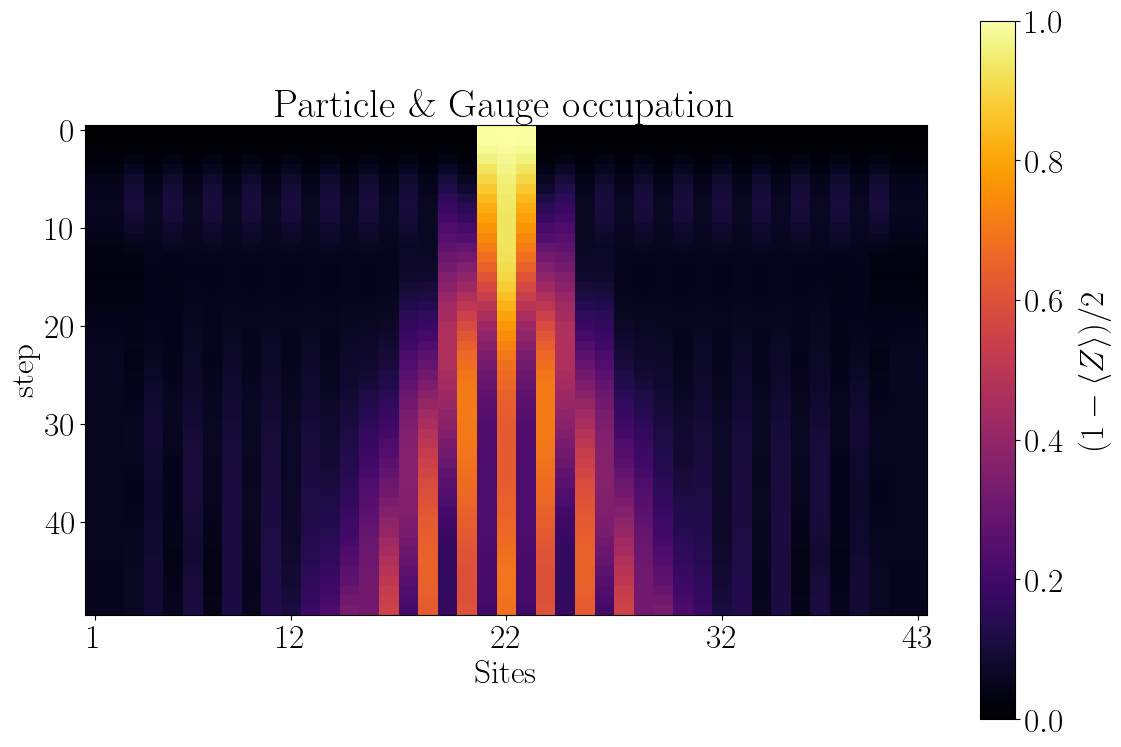

In [ ]:
from z2chain.plotting import x_t_plot, save_site_gauge_observable_matrix, load_site_gauge_observable_matrix
from z2chain.circs import particle_pair_quench_simulation_circuits
from utils.sexec import execute_simulation_estimator_batch
import os

estimator_options = {
    "default_precision": 0
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-8,
    "max_parallel_threads": 8,
    "max_parallel_experiments": 8
}

filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_bd_{mps_simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{estimator_options['default_precision']}.txt"

if os.path.exists(filepath):
    tn_site_gauge_observable_matrix = load_site_gauge_observable_matrix(filepath)
else:
    logical_circs = particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, measure_every_layers)
    observables_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]
    tn_site_gauge_observable_matrix = execute_simulation_estimator_batch(mps_simulator_options, estimator_options, logical_circs, observables_generating_funcs)
    save_site_gauge_observable_matrix(tn_site_gauge_observable_matrix, filepath)

x_t_plot(tn_site_gauge_observable_matrix, filepath=os.path.join("Plots", os.path.basename(os.path.split(filepath)[1])) + ".png")

In [ ]:
from z2chain.plotting import discrepancies_plot

discrepancies_plot(tn_site_gauge_observable_matrix, jobs)